# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [17]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=None, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.activation:
            y = self.activation(y)
        return y


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(num_features, n_hidden_1, tf.nn.sigmoid)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2, tf.nn.sigmoid)
    # Вихідний шар
    self.layer_3 = DenseLayer(n_hidden_2, num_classes, tf.nn.softmax)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)

    return self.layer_3(x)

In [18]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Отримання індексів максимальних значень для передбачень
    predicted_class = tf.argmax(y_pred, axis=1)
    # Порівняння передбачень зі справжніми значеннями
    correct_prediction = tf.equal(predicted_class, tf.cast(y_true, tf.int64))
    # Обчислення точності
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [19]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати Adam алгоритм
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [20]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)
    pred = neural_net(batch_x)
    current_loss = cross_entropy(pred, batch_y)
    current_accuracy = accuracy(pred, batch_y)
    loss_history.append(current_loss)
    accuracy_history.append(current_accuracy)

    if step % display_step == 0:
        print(f"Current Loss: {current_loss}")
        print(f"Current Accuracy: {current_accuracy}")

Current Loss: 364.63397216796875
Current Accuracy: 0.65625
Current Loss: 229.09417724609375
Current Accuracy: 0.78125
Current Loss: 188.88084411621094
Current Accuracy: 0.8046875
Current Loss: 125.47135162353516
Current Accuracy: 0.84765625
Current Loss: 97.00527954101562
Current Accuracy: 0.8984375
Current Loss: 103.98838806152344
Current Accuracy: 0.88671875
Current Loss: 118.33560180664062
Current Accuracy: 0.8828125
Current Loss: 81.48617553710938
Current Accuracy: 0.91015625
Current Loss: 61.171871185302734
Current Accuracy: 0.91796875
Current Loss: 67.09001159667969
Current Accuracy: 0.921875
Current Loss: 51.297508239746094
Current Accuracy: 0.9453125
Current Loss: 84.92898559570312
Current Accuracy: 0.91015625
Current Loss: 77.44168853759766
Current Accuracy: 0.9296875
Current Loss: 46.6667594909668
Current Accuracy: 0.953125
Current Loss: 65.86471557617188
Current Accuracy: 0.92578125
Current Loss: 64.00887298583984
Current Accuracy: 0.9453125
Current Loss: 17.27129554748535
C

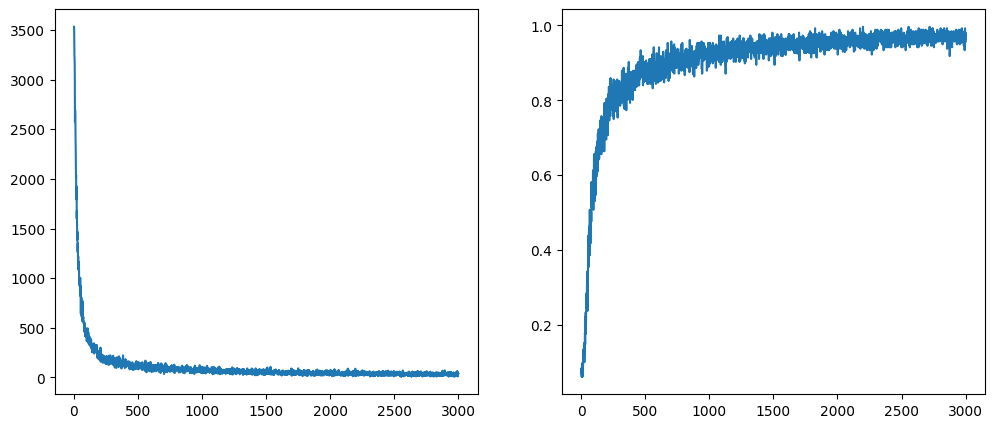

In [52]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
intervals = list(range(1, 3001))
axs[0].plot(intervals, loss_history)

# Виведіть графік точності
axs[1].plot(intervals, accuracy_history)
plt.show()

In [53]:
from sklearn.metrics import accuracy_score

# Отримання передбачень з тестових даних
predictions = neural_net(x_test)
# Отримання класів передбачень
predicted_classes = np.argmax(predictions, axis=1)

# Обчислення точності
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Точність моделі на тестових даних: {accuracy}")

Точність моделі на тестових даних: 0.9361


In [54]:
# Отримання передбачень моделі на тестових даних
predictions = neural_net(x_test)
predicted_classes = tf.argmax(predictions, axis=1)

# Виведення метрик якості за кожен клас
print(classification_report(y_test, predicted_classes, zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.92      0.91      0.92      1010
           4       0.93      0.93      0.93       982
           5       0.93      0.91      0.92       892
           6       0.96      0.95      0.96       958
           7       0.95      0.92      0.94      1028
           8       0.87      0.93      0.90       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [83]:
predicted_classes

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([7, 2, 1, ..., 4, 5, 6])>

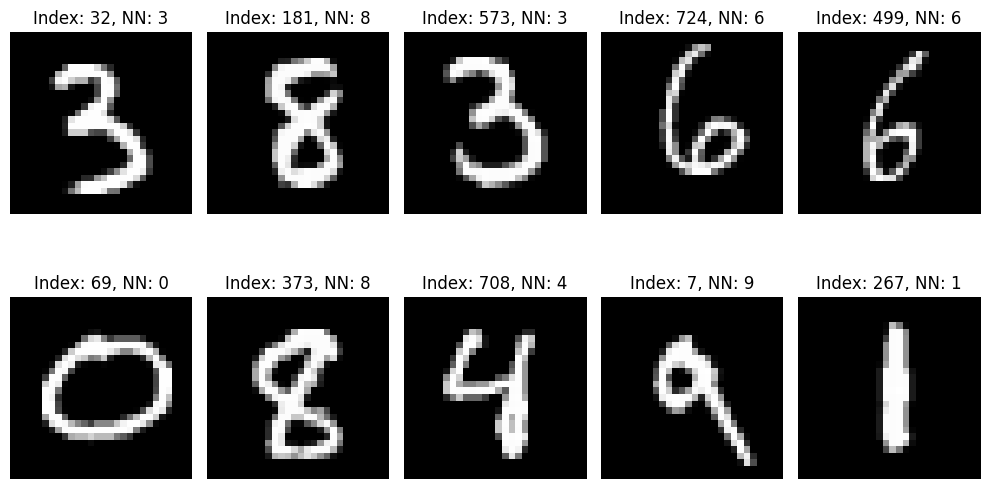

In [85]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
x_test[0].shape
random_list = np.random.randint(1, x_test[0].shape, size=10)
plt.figure(figsize=(10, 6))
for i, index in enumerate(random_list):
    nn_class = predicted_classes[index]
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[index].reshape((28, 28)), cmap='gray')
    plt.title(f"Index: {index}, NN: {nn_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [86]:
# Висновок: нейронна мережа працює корректно